In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import re
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error,f1_score

In [2]:
train_df = pd.read_csv("train.csv")

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
print("Count of NaN data in every column:")
train_df.isna().sum()

Count of NaN data in every column:


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
def fix_Name(df):
    titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    rare = ['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']    
    df['Title'] = df["Name"].str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    df['Title'] = df['Title'].replace(rare,'Rare')
    df['Title'] = df['Title'].map(titles)
    df['Title'] = df['Title'].fillna(0)
    return df

In [8]:
def new_Features(df):
    df['AgeClass'] = df.loc[:,'Age']*df.loc[:,'Pclass']
    df['SexAge'] = df.loc[:,'Sex']*df.loc[:,'Age']
    df["FamilySize"] = df["SibSp"]+df["Parch"]+1
    return df

In [9]:
def fix_Sex(df):
    df.loc[df['Sex'].isnull(), 'Sex'] = np.random.randint(0,2)
    genders = {"male": 0, "female": 1}
    df['Sex'] = df['Sex'].map(genders)
    df['Sex'] = df['Sex'].astype(int)
    return df

In [10]:
def fix_Age(df):
    mean = df["Age"].mean()
    std = df["Age"].std()
    is_null = df["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    df.loc[df['Age'].isnull(), 'Age'] = rand_age
    df['Age'] = df['Age'].astype(int)
    return df

In [11]:
def fix_Fare(df):
    df.loc[df['Fare'].isnull(), 'Fare'] = 0
    df['Fare'] = df['Fare']/df['Fare'].mean()
    #df['Fare'] = df['Fare'].astype(int)
    return df

In [12]:
def fix_Cabin(df):
    deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
    df['Cabin'] = df['Cabin'].fillna("U0")
    df['Deck'] = df['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    df['Deck'] = df['Deck'].map(deck)
    df['Deck'] = df['Deck'].fillna(0)
    df['Deck'] = df['Deck'].astype(int)
    return df

In [13]:
def fix_Embarked(df):
    ports = {"S": 0, "C": 1, "Q": 2}
    df['Embarked'] = df['Embarked'].fillna('S')
    df['Embarked'] = df['Embarked'].map(ports)
    return df

In [14]:
def rm(df):
    df = df.drop(['PassengerId'], axis=1)
    df = df.drop(['Name'], axis=1)
    df = df.drop(['Ticket'], axis=1)
    df = df.drop(['Cabin'], axis=1)
    return df

In [15]:
def cabin(df):
    df['CabinFlag'] = df['Cabin'].apply(lambda x: 0 if type(x)==float else 1)
    return df

In [16]:
def data_train_pp(df):
    df = cabin(df)
    df = fix_Name(df)
    df = fix_Sex(df)
    df = fix_Age(df)
    df = fix_Cabin(df)
    df = fix_Fare(df)
    df = fix_Embarked(df)
    df = new_Features(df)
    df = rm(df)
    df = df.drop(['Survived'], axis=1)
    return df

In [17]:
train_x = data_train_pp(train_df)
train_x.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,CabinFlag,Title,Deck,AgeClass,SexAge,FamilySize
0,3,0,22,1,0,0.225126,0,0,1,8,66,0,2
1,1,1,38,1,0,2.213478,1,1,3,3,38,38,2
2,3,1,26,0,0,0.246086,0,0,2,8,78,26,1
3,1,1,35,1,0,1.648853,0,1,3,3,35,35,2
4,3,0,35,0,0,0.249967,0,0,1,8,105,0,1


In [18]:
train_y = train_df['Survived']
train_y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [19]:
def showData(df, df1):
    for i in range(len(df.columns)):
        Parameters = df.columns[i]
        plt.hist(x = [df[df1['Survived']==1][Parameters], df[df1['Survived']==0][Parameters]], label = ['Survived','Dead'])
        plt.title('Survival')
        plt.xlabel(Parameters)
        plt.ylabel('Number of Passengers')
        plt.legend()
        plt.show()

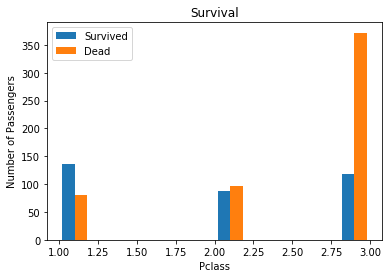

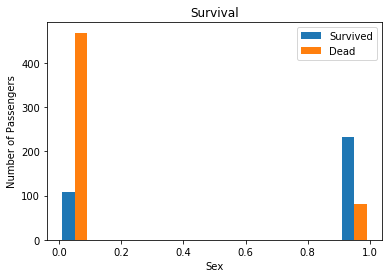

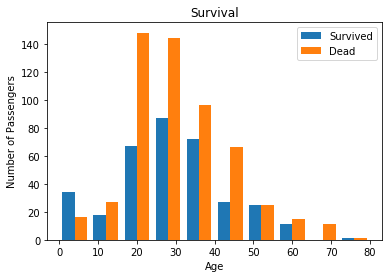

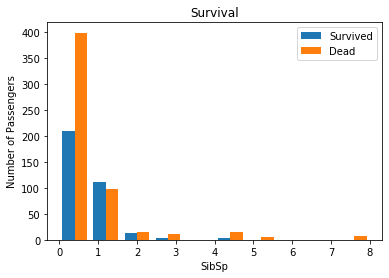

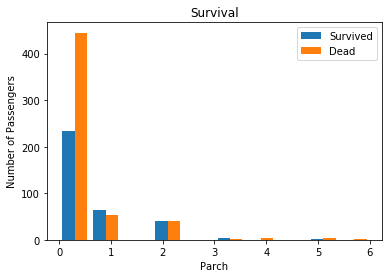

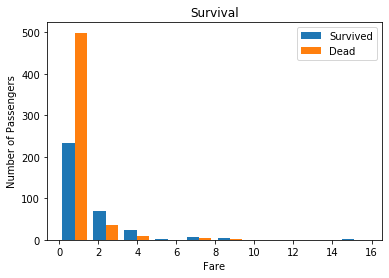

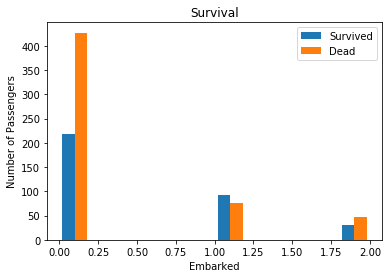

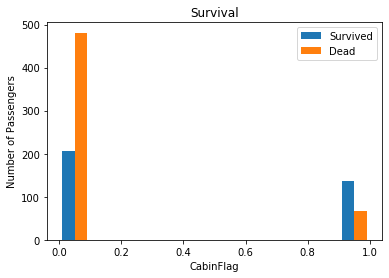

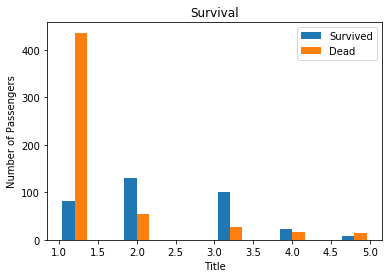

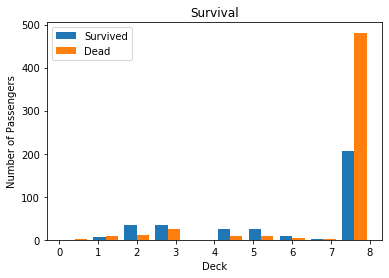

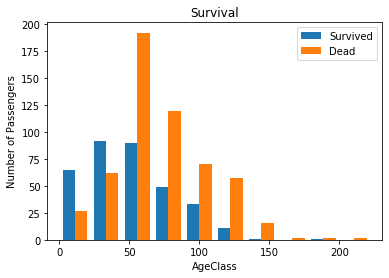

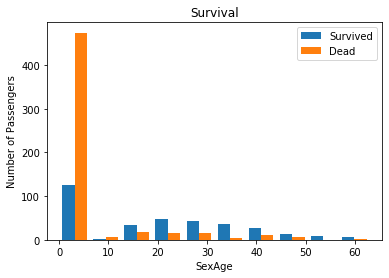

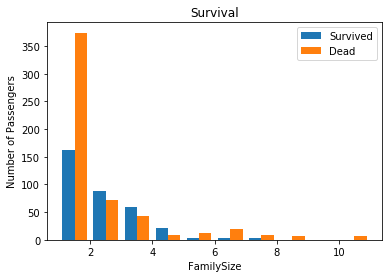

In [20]:
showData(train_x,train_df)

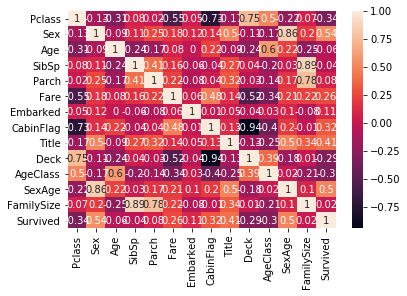

In [21]:
mat = train_x.copy()
mat ['Survived' ] = train_y.astype(int)

correlation_matrix = mat.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)

In [22]:
train_x.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
       'CabinFlag', 'Title', 'Deck', 'AgeClass', 'SexAge', 'FamilySize'],
      dtype='object')

In [23]:
train_x = train_x.drop(['SibSp', 'Fare'], axis=1)

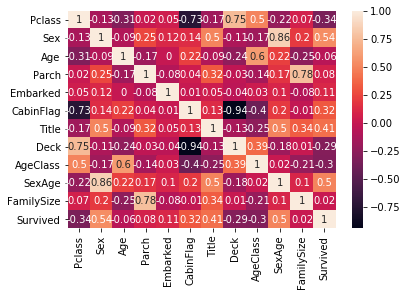

In [24]:
mat = train_x.copy()
mat ['Survived' ] = train_y.astype(int)

correlation_matrix = mat.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)

In [25]:
train_x.columns

Index(['Pclass', 'Sex', 'Age', 'Parch', 'Embarked', 'CabinFlag', 'Title',
       'Deck', 'AgeClass', 'SexAge', 'FamilySize'],
      dtype='object')

In [26]:
import sklearn.model_selection as model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_x, train_y, train_size=0.8,test_size=0.2, random_state=101)
print ("X_train: ", X_train.shape)
print ("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print ("y_test: ", y_test.shape)

X_train:  (712, 11)
y_train:  (712,)
X_test:  (179, 11)
y_test:  (179,)


In [27]:
#Logistic Regression:

logisticRegression = LogisticRegression()
logisticRegression.fit(X_train, y_train)
predictions = logisticRegression.predict(X_test)
acc_log = accuracy_score(y_test, predictions)
mseLR = mean_squared_error(y_test,predictions)
maeLR = mean_absolute_error (y_test,predictions)
F1LR = f1_score(y_test,predictions,average='weighted')

print('Test Accuracy: ', acc_log)
print('Test RMS: ', mseLR)
print("Test MAE: ", maeLR)
print("F1 - Score : ", F1LR )

Test Accuracy:  0.8100558659217877
Test RMS:  0.18994413407821228
Test MAE:  0.18994413407821228
F1 - Score :  0.8082903595473427


C:\Users\urvi3\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [28]:
#K Nearest Neighbor:
knn = KNeighborsClassifier(n_neighbors = 3) 
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)
acc_knn = accuracy_score(y_test, predictions)
mseLR = mean_squared_error(y_test,predictions)
maeLR = mean_absolute_error (y_test,predictions)
F1LR = f1_score(y_test,predictions,average='weighted')

print('Test Accuracy: ', acc_knn)
print('Test RMS: ', mseLR)
print("Test MAE: ", maeLR)
print("F1 - Score : ", F1LR )

Test Accuracy:  0.7821229050279329
Test RMS:  0.21787709497206703
Test MAE:  0.21787709497206703
F1 - Score :  0.777785914228684


In [29]:
#Decision Tree:

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
predictions = tree.predict(X_test)
acc_decision_tree = accuracy_score(y_test, predictions)
mseLR = mean_squared_error(y_test,predictions)
maeLR = mean_absolute_error (y_test,predictions)
F1LR = f1_score(y_test,predictions,average='weighted')

print('Test Accuracy: ', acc_decision_tree)
print('Test RMS: ', mseLR)
print("Test MAE: ", maeLR)
print("F1 - Score : ", F1LR )

Test Accuracy:  0.7541899441340782
Test RMS:  0.24581005586592178
Test MAE:  0.24581005586592178
F1 - Score :  0.7519051711789141


In [30]:
#Linear Support Vector Machine:

svm = LinearSVC()
svm.fit(X_train, y_train)
predictions = svm.predict(X_test)
acc_linear_svc = accuracy_score(y_test, predictions)
mseLR = mean_squared_error(y_test,predictions)
maeLR = mean_absolute_error (y_test,predictions)
F1LR = f1_score(y_test,predictions,average='weighted')

print('Test Accuracy: ', acc_linear_svc)
print('Test RMS: ', mseLR)
print("Test MAE: ", maeLR)
print("F1 - Score : ", F1LR )

Test Accuracy:  0.7821229050279329
Test RMS:  0.21787709497206703
Test MAE:  0.21787709497206703
F1 - Score :  0.7719239973976705


C:\Users\urvi3\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [31]:
#Gaussian Naive Bayes:

nb = GaussianNB()
nb.fit(X_train, y_train)
predictions = nb.predict(X_test)
acc_gaussian = accuracy_score(y_test, predictions)
mseLR = mean_squared_error(y_test,predictions)
maeLR = mean_absolute_error (y_test,predictions)
F1LR = f1_score(y_test,predictions,average='weighted')

print('Test Accuracy: ', acc_gaussian)
print('Test RMS: ', mseLR)
print("Test MAE: ", maeLR)
print("F1 - Score : ", F1LR )

Test Accuracy:  0.8044692737430168
Test RMS:  0.19553072625698323
Test MAE:  0.19553072625698323
F1 - Score :  0.8049841993161297


In [32]:
#Perceptron:

perceptron = Perceptron(max_iter=10)
perceptron.fit(X_train, y_train)
predictions = perceptron.predict(X_test)
acc_perceptron = accuracy_score(y_test, predictions)
mseLR = mean_squared_error(y_test,predictions)
maeLR = mean_absolute_error (y_test,predictions)
F1LR = f1_score(y_test,predictions,average='weighted')

print('Test Accuracy: ', acc_perceptron)
print('Test RMS: ', mseLR)
print("Test MAE: ", maeLR)
print("F1 - Score : ", F1LR )

Test Accuracy:  0.44692737430167595
Test RMS:  0.553072625698324
Test MAE:  0.553072625698324
F1 - Score :  0.2760941308427342


C:\Users\urvi3\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [33]:
#Random Forest:

random_forest = RandomForestClassifier(n_estimators=100, oob_score=True)
random_forest.fit(X_train, y_train)
predictions = random_forest.predict(X_test)
acc_random_forest = accuracy_score(y_test, predictions)
mseLR = mean_squared_error(y_test,predictions)
maeLR = mean_absolute_error (y_test,predictions)
F1LR = f1_score(y_test,predictions,average='weighted')

print('Test Accuracy: ', acc_random_forest)
print('Test RMS: ', mseLR)
print("Test MAE: ", maeLR)
print("F1 - Score : ", F1LR )

Test Accuracy:  0.7932960893854749
Test RMS:  0.20670391061452514
Test MAE:  0.20670391061452514
F1 - Score :  0.7898828145137441


In [37]:
from sklearn.metrics import roc_auc_score

y_scores = logisticRegression.predict_proba(X_test)
y_scores = y_scores[:,1]
r_a_score = roc_auc_score(y_test, y_scores)
print("ROC-AUC-Score:", r_a_score)

ROC-AUC-Score: 0.8726010101010101


In [38]:
importances = pd.DataFrame({'feature':train_x.columns,'importance':np.round(random_forest.feature_importances_,4)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

importances.head(12)

,importance
feature,
SexAge,0.1728
AgeClass,0.1696
Age,0.1459
Title,0.1302
Sex,0.0947
FamilySize,0.0815
Pclass,0.0637
Deck,0.0512
Embarked,0.0441


In [36]:
results = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Decision Tree'],
    'Score': [acc_linear_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_decision_tree]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head(8)

,Model
Score,
0.810056,Logistic Regression
0.804469,Naive Bayes
0.793296,Random Forest
0.782123,Support Vector Machines
0.782123,KNN
0.754190,Decision Tree
0.446927,Perceptron
